In [1]:
from google.colab import files
files.upload()  # upload your kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# --- STEP 2: Download dataset from Kaggle ---
!kaggle datasets download -d noulam/tomato

# --- STEP 3: Unzip dataset ---
!unzip -q tomato.zip -d dataset/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/noulam/tomato
License(s): copyright-authors
 99% 735M/743M [00:04<00:00, 41.6MB/s]
100% 743M/743M [00:04<00:00, 187MB/s] 


In [2]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

In [3]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    'dataset',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

val_gen = datagen.flow_from_directory(
    'dataset',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 36688 images belonging to 2 classes.
Found 9172 images belonging to 2 classes.


In [4]:
#Feature extraction

base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(128,128,3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

#Extract features
print("Extracting features for training set...")
features_train = feature_extractor.predict(train_gen, verbose=1)
labels_train = train_gen.classes

print("Extracting features for validation set...")
features_val = feature_extractor.predict(val_gen, verbose=1)
labels_val = val_gen.classes

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Extracting features for training set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1147/1147 ━━━━━━━━━━━━━━━━━━━━ 64s 46ms/step
Extracting features for validation set...
287/287 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step


In [6]:
!rm -rf "/content/dataset/new plant diseases dataset(augmented)"


In [7]:
!mv "/content/dataset/New Plant Diseases Dataset(Augmented)" "/content/dataset/tomato_dataset"


In [8]:
!ls /content/dataset/tomato_dataset


train  valid


In [9]:
# 1️⃣ Clean up duplicates
!rm -rf "/content/dataset/new plant diseases dataset(augmented)"

# 2️⃣ Rename the remaining folder to something clean
!mv "/content/dataset/New Plant Diseases Dataset(Augmented)" "/content/dataset/tomato_dataset"

# 3️⃣ Check structure
!ls /content/dataset/tomato_dataset


mv: cannot stat '/content/dataset/New Plant Diseases Dataset(Augmented)': No such file or directory
train  valid


In [10]:
!ls /content/dataset/tomato_dataset/train


 Tomato___Bacterial_spot   Tomato___Septoria_leaf_spot
 Tomato___Early_blight	  'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___healthy	   Tomato___Target_Spot
 Tomato___Late_blight	   Tomato___Tomato_mosaic_virus
 Tomato___Leaf_Mold	   Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [11]:
train_dir = '/content/dataset/tomato_dataset/train'
val_dir   = '/content/dataset/tomato_dataset/valid'

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)


Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


✅ MobileNetV2 feature extractor loaded!
🔹 Extracting features for training data...


100%|██████████| 574/574 [01:18<00:00,  7.34it/s]


🔹 Extracting features for validation data...


100%|██████████| 144/144 [00:16<00:00,  8.75it/s]


✅ Feature extraction complete!
Train features shape: (18345, 1280)
Validation features shape: (4585, 1280)

🌲 Training Random Forest (100 trees)...

🔹 Evaluating model ...

✅ Validation Accuracy: 82.07%

📊 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.81      0.91      0.86       425
                        Tomato___Early_blight       0.75      0.67      0.71       480
                         Tomato___Late_blight       0.86      0.79      0.82       463
                           Tomato___Leaf_Mold       0.81      0.81      0.81       470
                  Tomato___Septoria_leaf_spot       0.79      0.74      0.76       436
Tomato___Spider_mites Two-spotted_spider_mite       0.75      0.84      0.79       435
                         Tomato___Target_Spot       0.70      0.68      0.69       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.93      0.93      0.

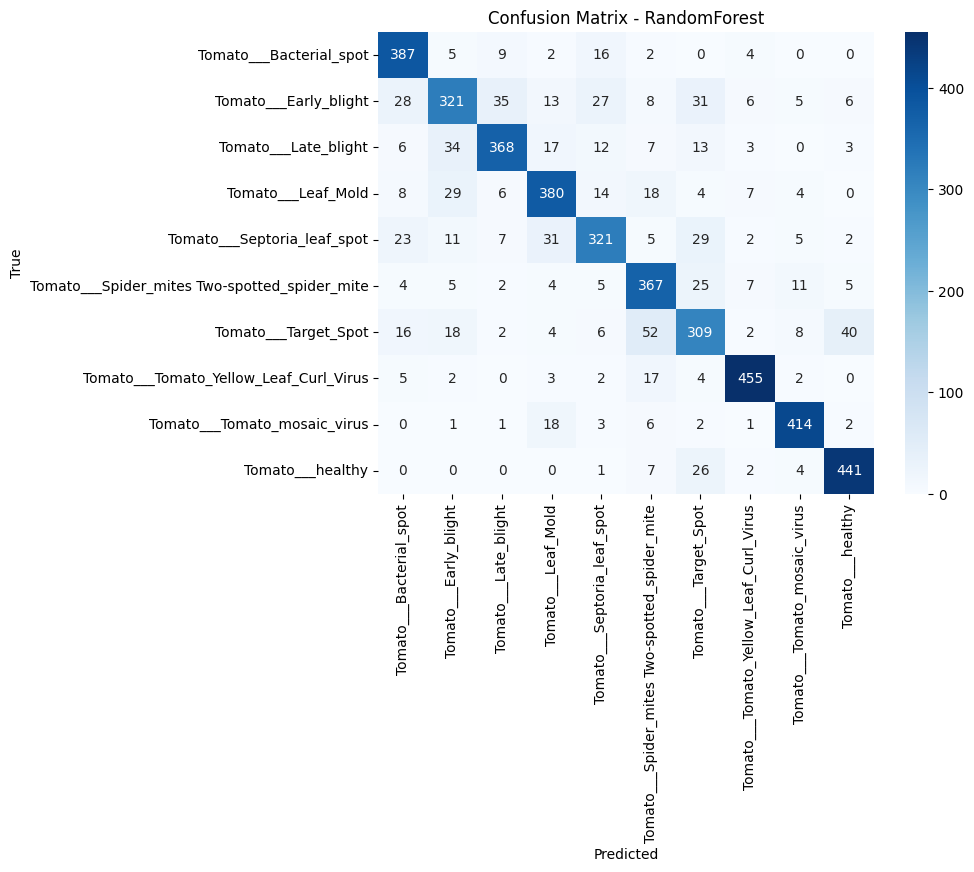

💾 Model saved as 'best_model_RF.pkl'


In [12]:
# 🌿 Step 8: MobileNetV2 + RandomForest Classifier (Fast & Accurate)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

# --- Step 1: Load MobileNetV2 base (no top layer) ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

print("✅ MobileNetV2 feature extractor loaded!")

# --- Step 2: Extract features for train and validation sets ---
def extract_features(generator):
    features = []
    labels = []
    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        f = model.predict(x_batch, verbose=0)
        features.append(f)
        labels.append(y_batch)
    return np.concatenate(features), np.concatenate(labels)

print("🔹 Extracting features for training data...")
features_train, labels_train = extract_features(train_gen)

print("🔹 Extracting features for validation data...")
features_val, labels_val = extract_features(val_gen)

print("✅ Feature extraction complete!")
print("Train features shape:", features_train.shape)
print("Validation features shape:", features_val.shape)

# --- Step 3: Train Random Forest ---
print("\n🌲 Training Random Forest (100 trees)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(features_train, labels_train)

# --- Step 4: Evaluate ---
print("\n🔹 Evaluating model ...")
y_pred = rf_model.predict(features_val)
acc = accuracy_score(labels_val, y_pred)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

# --- Classification Report ---
target_names = list(train_gen.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(labels_val, y_pred, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(labels_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - RandomForest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Step 5: Save the trained model ---
joblib.dump(rf_model, 'best_model_RF.pkl')
print("💾 Model saved as 'best_model_RF.pkl'")


🔹 Training Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



🔹 Evaluating...

✅ Validation Accuracy: 90.88%

📊 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.94      0.94      0.94       425
                        Tomato___Early_blight       0.81      0.84      0.83       480
                         Tomato___Late_blight       0.91      0.89      0.90       463
                           Tomato___Leaf_Mold       0.92      0.92      0.92       470
                  Tomato___Septoria_leaf_spot       0.89      0.86      0.87       436
Tomato___Spider_mites Two-spotted_spider_mite       0.87      0.91      0.89       435
                         Tomato___Target_Spot       0.86      0.81      0.83       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98      0.99      0.98       490
                 Tomato___Tomato_mosaic_virus       0.96      0.97      0.97       448
                             Tomato___healthy       0.9

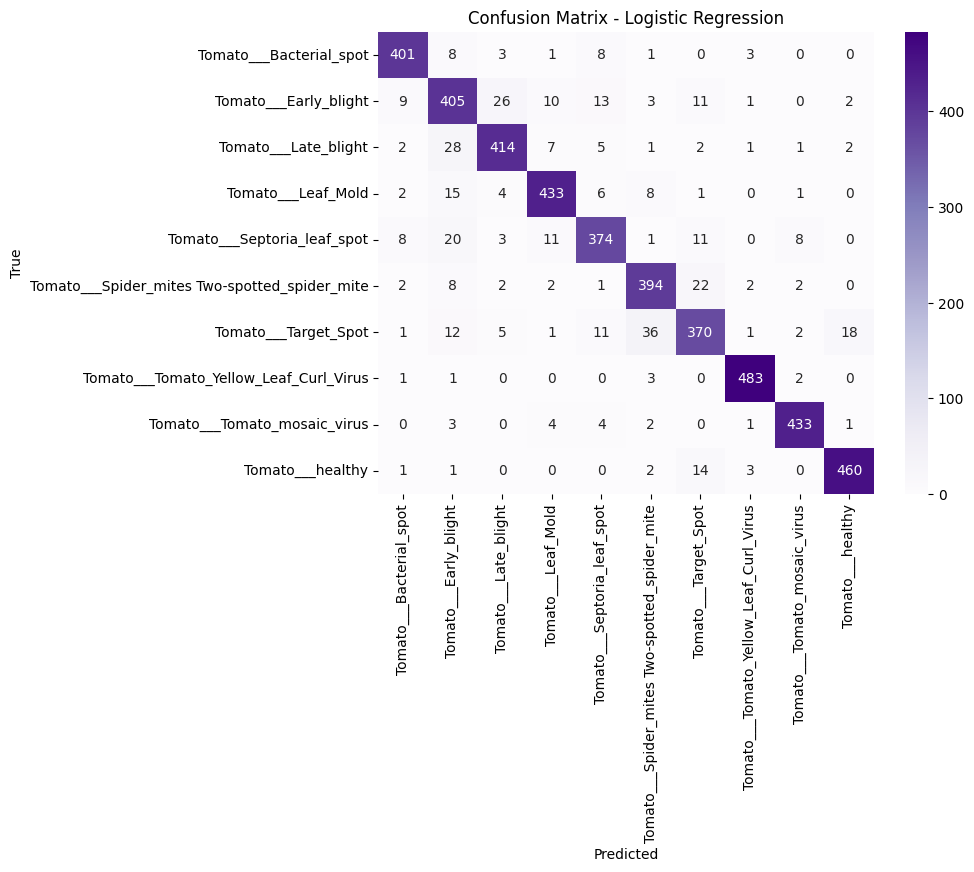

💾 Model saved as 'best_model_LR.pkl'


In [13]:
# 🌿 Step 9: Train Logistic Regression on MobileNet Features
# ==========================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

print("🔹 Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=200, n_jobs=-1, verbose=1)
lr_model.fit(features_train, labels_train)

print("\n🔹 Evaluating...")
y_pred = lr_model.predict(features_val)
acc = accuracy_score(labels_val, y_pred)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

target_names = list(train_gen.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(labels_val, y_pred, target_names=target_names))

cm = confusion_matrix(labels_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

joblib.dump(lr_model, 'best_model_LR.pkl')
print("💾 Model saved as 'best_model_LR.pkl'")


In [ ]:
# 🌿 Step 8: MobileNetV2 + RandomForest Classifier (Fast & Accurate)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

# --- Step 1: Load MobileNetV2 base (no top layer) ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

print("✅ MobileNetV2 feature extractor loaded!")

# --- Step 2: Extract features for train and validation sets ---
def extract_features(generator):
    features = []
    labels = []
    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        f = model.predict(x_batch, verbose=0)
        features.append(f)
        labels.append(y_batch)
    return np.concatenate(features), np.concatenate(labels)

print("🔹 Extracting features for training data...")
features_train, labels_train = extract_features(train_gen)

print("🔹 Extracting features for validation data...")
features_val, labels_val = extract_features(val_gen)

print("✅ Feature extraction complete!")
print("Train features shape:", features_train.shape)
print("Validation features shape:", features_val.shape)

# --- Step 3: Train Random Forest ---
print("\n🌲 Training Random Forest (100 trees)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(features_train, labels_train)

# --- Step 4: Evaluate ---
print("\n🔹 Evaluating model ...")
y_pred = rf_model.predict(features_val)
acc = accuracy_score(labels_val, y_pred)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

# --- Classification Report ---
target_names = list(train_gen.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(labels_val, y_pred, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(labels_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - RandomForest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Step 5: Save the trained model ---
joblib.dump(rf_model, 'best_model_RF.pkl')
print("💾 Model saved as 'best_model_RF.pkl'")


🧩 Using subset of 5000 samples for quick training...
🌲 Training Random Forest model...

🔹 Evaluating model ...

✅ Validation Accuracy: 79.52%

📊 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.78      0.89      0.83       425
                        Tomato___Early_blight       0.72      0.61      0.66       480
                         Tomato___Late_blight       0.79      0.80      0.79       463
                           Tomato___Leaf_Mold       0.77      0.76      0.76       470
                  Tomato___Septoria_leaf_spot       0.79      0.71      0.75       436
Tomato___Spider_mites Two-spotted_spider_mite       0.73      0.81      0.77       435
                         Tomato___Target_Spot       0.68      0.60      0.64       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.91      0.91      0.91       490
                 Tomato___Tomato_mosaic_virus   

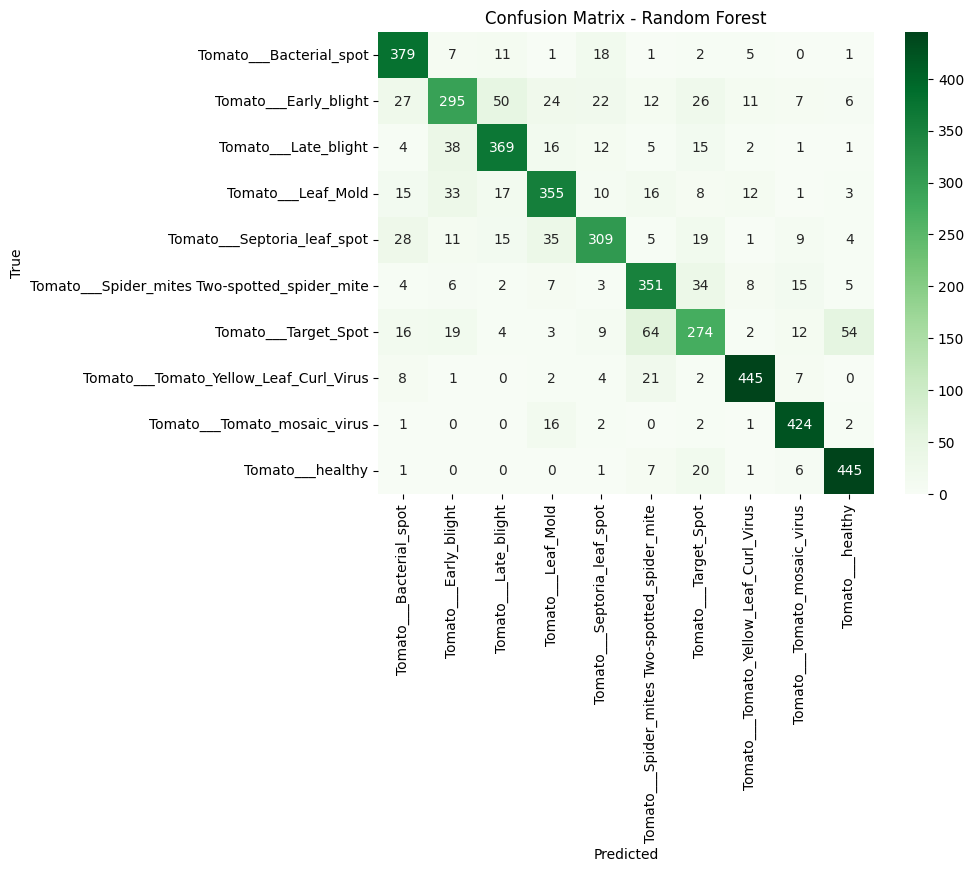

💾 Model saved as 'best_model_RF.pkl'


In [14]:
# 🌿 Step 8: Train & Evaluate Random Forest (Faster & More Accurate)
# ================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- Optional: Use subset if dataset is huge ---
sample = 5000  # use fewer if you want faster runs (e.g. 3000)
indices = random.sample(range(len(features_train)), sample)
features_train_sub = features_train[indices]
labels_train_sub = labels_train[indices]

print(f"🧩 Using subset of {sample} samples for quick training...")

# --- Train Random Forest ---
print("🌲 Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # let trees grow fully
    min_samples_split=2,
    n_jobs=-1,               # use all CPU cores
    random_state=42
)
rf_model.fit(features_train_sub, labels_train_sub)

# --- Evaluate ---
print("\n🔹 Evaluating model ...")
y_pred = rf_model.predict(features_val)
acc = accuracy_score(labels_val, y_pred)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

# --- Classification report ---
target_names = list(train_gen.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(labels_val, y_pred, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(labels_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Save model ---
joblib.dump(rf_model, 'best_model_RF.pkl')
print("💾 Model saved as 'best_model_RF.pkl'")


In [16]:
# ======================================
# 🌿 Step 8: Train Multiple ML Models & Compare
# ======================================

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Train-validation data already prepared:
# features_train, labels_train, features_val, labels_val

# --- Train SVM ---
print("🔹 Training SVM...")
svm_model = SVC(kernel='linear', C=3, probability=True)
svm_model.fit(features_train, labels_train)
svm_pred = svm_model.predict(features_val)
svm_acc = accuracy_score(labels_val, svm_pred)
print(f"SVM Accuracy: {svm_acc:.4f}")

# --- Train Random Forest ---
print("\n🔹 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=80, random_state=42)
rf_model.fit(features_train, labels_train)
rf_pred = rf_model.predict(features_val)
rf_acc = accuracy_score(labels_val, rf_pred)
print(f"RandomForest Accuracy: {rf_acc:.4f}")

# --- Train Logistic Regression ---
print("\n🔹 Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=40, solver='lbfgs', multi_class='auto')
lr_model.fit(features_train, labels_train)
lr_pred = lr_model.predict(features_val)
lr_acc = accuracy_score(labels_val, lr_pred)
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")

# --- Compare models ---
print("\n✅ Model Performance Summary:")
print(f"SVM: {svm_acc:.4f}")
print(f"RandomForest: {rf_acc:.4f}")
print(f"Logistic Regression: {lr_acc:.4f}")

best_model = None
best_name = ""
best_acc = 0.0

for name, model, acc in [
    ("SVM", svm_model, svm_acc),
    ("RandomForest", rf_model, rf_acc),
    ("LogisticRegression", lr_model, lr_acc)
]:
    if acc > best_acc:
        best_model = model
        best_name = name
        best_acc = acc

print(f"\n🏆 Best Model: {best_name} with accuracy {best_acc:.4f}")

# --- Save the best model ---
joblib.dump(best_model, f'best_model_{best_name}.pkl')
print(f"✅ Saved best model as 'best_model_{best_name}.pkl'")

# --- Optional: Detailed classification report for best model ---
print("\nDetailed Classification Report:")
best_pred = best_model.predict(features_val)
print(classification_report(labels_val, best_pred, target_names=list(train_gen.class_indices.keys())))

🔹 Training SVM...
SVM Accuracy: 0.9128

🔹 Training Random Forest...
RandomForest Accuracy: 0.8131

🔹 Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9003

✅ Model Performance Summary:
SVM: 0.9128
RandomForest: 0.8131
Logistic Regression: 0.9003

🏆 Best Model: SVM with accuracy 0.9128
✅ Saved best model as 'best_model_SVM.pkl'

Detailed Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.92      0.97      0.94       425
                        Tomato___Early_blight       0.81      0.86      0.83       480
                         Tomato___Late_blight       0.92      0.91      0.92       463
                           Tomato___Leaf_Mold       0.92      0.91      0.91       470
                  Tomato___Septoria_leaf_spot       0.91      0.85      0.88       436
Tomato___Spider_mites Two-spotted_spider_mite       0.87      0.88      0.87       435
                         Tomato___Target_Spot       0.87      0.82      0.84       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.98   